<a href="https://colab.research.google.com/github/JamilyaSultan/INDE-597-Deep-and-Reinforcement-Learning/blob/main/Copy_of_grid_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temporal Difference Learning 

The Bellman equation caculates the value of states when the model $P$ of the problem is known. For model-free problems, we need another solution method; a solution method that can work by sampling. 

Perhaps the best known solution method for estimating policy functions is temporal difference learning. The name temporal difference refers to the difference that is calculated between two time steps, which is used to calculate the value of the new time step. 

The Bellman equation describes how $V(s)$ can be calculated using dynamic programming when the transition function $P$ is known. It is a model-based planning method. TD is different: under the policy $\pi$ it samples from the environment to adjust the current $V(s)$ estimate using a learning rate. TD does not need to know the transition function $P$ and finds $V(s)$ by sampling. 

TD works by updating the current estimate of the state $V(s)$ with an error value based on the estimate of the next state (in this sense it is similar to supervised machine learning). It is, therefore, a bootstrapping method, where the update takes into account the previous estimates:

$$
V(S_t) \leftarrow V(S_t) + \alpha [R_{t+1} + \gamma V(S_{t+1}) - V(S_t)]
$$

## On-Policy Learning and Off-Policy Learning
We will now discuss two model-free solution methods, methods that work when the transition function of the MDP is not known. 

Recall that reinforcement learning is concerned with learning a policy from actions and rewards. The agent selects an action, and learns from the reward that it gets back from the environment. Normally, the learning takes place by backing up the value of the action that was selected by the policy: the learning is *on-policy learning*. It turns out that there is an alternative. If the learning takes place by backing up values of another action, not the one selected by the policy, then this is known as *off-policy learning*. This makes sense when the policy explores by selecting non-optimal actions. 

Before moving forward, recall that $Q(s, a)$ is approximating the expected value of selecting an action $a$ in the state $s$. On-policy and off-policy learning update $Q(s, a)$ by backing up values from their successor actions. When the algorithms sample the state/action pairs often enough, the algorithms are proven to converge to the correct values. 

---

In [ ]:
# User friendly interface to work with RL applied to grid world. 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Define a custom gridworld environment 
class GridWorld2(object):
    def __init__(self, initial_state, grid_size, items, terminal_states):
        self.step_reward = -1
        self.initial_state = initial_state
        self.m = grid_size[0]
        self.n = grid_size[1]
        self.grid = np.zeros(grid_size)
        self.items = items
        self.terminal_states = terminal_states

        self.state_space = []
        for i in range(self.m):
            for j in range(self.n):
                self.state_space.append((i, j))

        self.action_space = [0, 1, 2, 3]

    def step(self, state, action):
        if action == 0: # up
            next_state = (state[0] - 1, state[1])
        elif action == 1: # down
            next_state = (state[0] + 1, state[1])
        elif action == 2: # left
            next_state = (state[0], state[1] - 1)
        else: # right
            next_state = (state[0], state[1] + 1)

        if next_state[0] < 0:
            next_state = state
        if next_state[0] > self.m - 1:
            next_state = state
        if next_state[1] < 0:
            next_state = state
        if next_state[1] > self.n - 1:
            next_state = state

        if next_state in self.items:
            reward = self.step_reward + self.items[next_state]
        else:
            reward = self.step_reward

        return next_state, reward, next_state in self.terminal_states

    def reset(self):
        return self.initial_state, 0.0, False

    def show(self, state):
        plt.figure(figsize=(7, 7))
        matrix = np.copy(self.grid)
        matrix[state[0]][state[1]] = 5.0
        for val in self.items:
            matrix[val[0]][val[1]] =   self.items[val]

        return sns.heatmap(matrix, linewidth = 0.5, cmap="rocket")


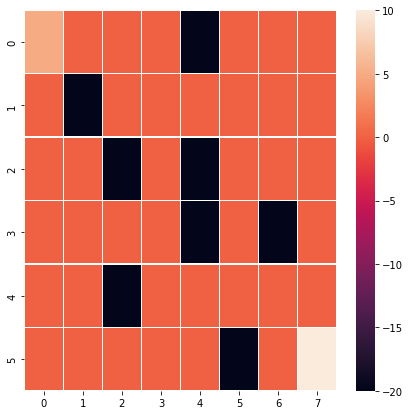

In [ ]:
initial_state = (0, 0)
grid_size = (6, 8)
items = {(5, 7): 10,
         (4, 2): -20,
         (2, 2): -20, 
         (2, 2): -20,
         (2, 2): -20, 
         (0, 4): -20, 
         (1, 1): -20, 
         (2, 4): -20,
         (3, 6): -20,
         (5, 5): -20, 
         (3, 4): -20}
terminal_states = items.keys()
env = GridWorld2(initial_state, grid_size, items, terminal_states)
env.show(initial_state)

In [ ]:
def epsilon_greedy_policy(env, Q, state, epsilon):
    if np.random.normal(0, 1) < epsilon:
        return np.random.choice(env.action_space)
    else:
        return np.argmax(Q[state])

---

## On-Policy
In on-policy learning a single policy is used for action selection and for value backup towards a learning target. On-policy learning updates values directly on this single policy. The same policy array (or function) is used for exploration behavior and for the incumbent target policy. The update formula is:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)]
$$

On-policy learning selects an action, evaluates it, and moves on to better actions. A well-known on-policy approach is SARSA (state-action-reward-state-action). On-policy learning starts with a starting policy, samples the state space with this policy, and improves the policy by backing up values of the selected actions. Note that $Q(S_{t+1}, A_{t+1})$ can also be written as $Q(S_{t+1}, \pi(S_{t+1})$, highlighting the difference with off-policy learning. Since SARSA is on-policy, it updates its $Q$-values using the $Q$-value of the next state and current policy action. 

The primary advantage of on-policy learning is that it directly optimizes the target of interest, and achieves stable learning. The biggest drawback is sample inefficiency, since policies are estimated from the full rollouts. This may further cause large variance--if it goes in the wrong direction, there is no stablizing other information to get it out. 



---

In [ ]:
def sarsa(env, iterations = 5_000):
    Q = {}
    for state in env.state_space:
        Q[state] = np.zeros(4)
    gamma = 0.9
    alpha = 0.05
    epsilon = 0.1
    R = []
    for episode in range(iterations):
        state, total_reward, done = env.reset()
        counter = 0
        while not done:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.choice(env.action_space)
            else:
                action = np.argmax(Q[state])
            next_state, reward, done = env.step(state, action)


            if np.random.uniform(0, 1) < epsilon:
                next_action = np.random.choice(env.action_space)
            else:
                next_action = np.argmax(Q[next_state])
            

            old_value = Q[state][action]

            new_value = old_value + alpha * (reward + gamma * Q[next_state][next_action] - old_value)

            Q[state][action] = new_value
            total_reward += reward
            state = next_state
            counter += 1
        if episode % 500 == 0:
            print(f"Episode {episode} with average reward {total_reward}")
        
        R.append(total_reward)
        
    return Q, R

Episode 0 with average reward -28.0
Episode 500 with average reward -4.0
Episode 1000 with average reward -6.0
Episode 1500 with average reward -2.0
Episode 2000 with average reward -4.0
Episode 2500 with average reward -2.0
Episode 3000 with average reward -2.0
Episode 3500 with average reward -4.0
Episode 4000 with average reward -2.0
Episode 4500 with average reward -2.0


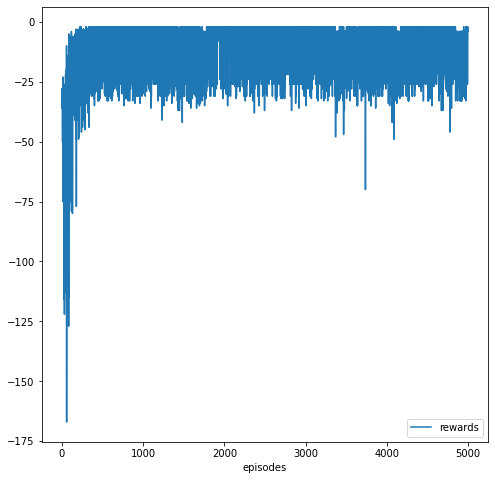

In [ ]:
Q, R = sarsa(env)

plt.figure(figsize = (8, 8))
plt.plot(range(5_000), R, label = "rewards")
plt.xlabel("episodes")
plt.legend()
plt.show()

-2.0


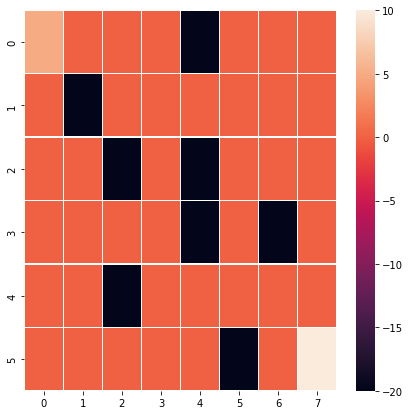

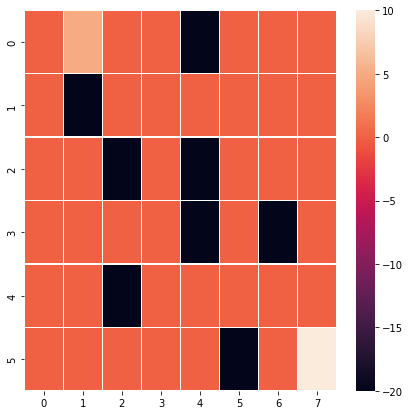

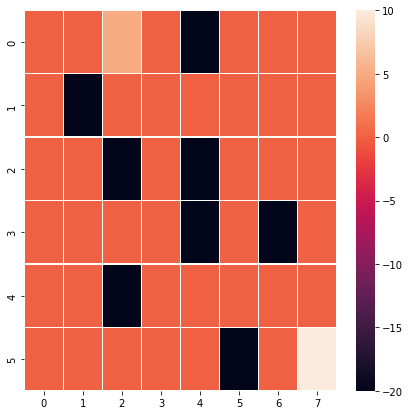

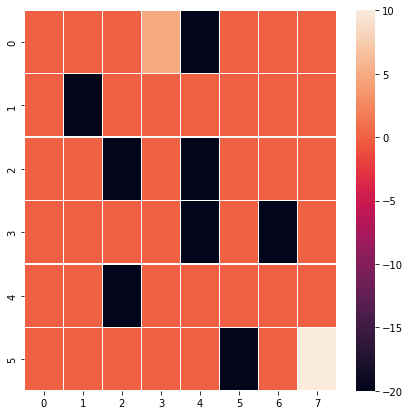

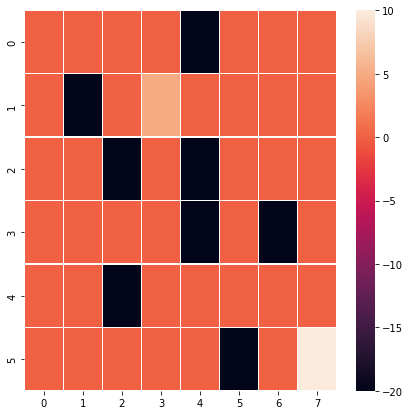

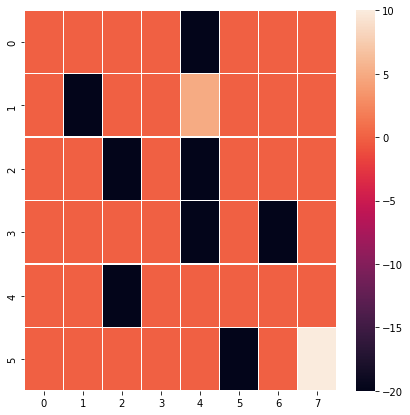

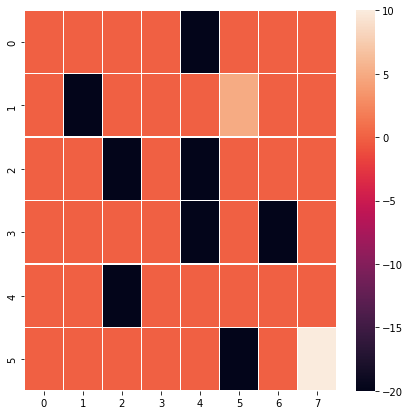

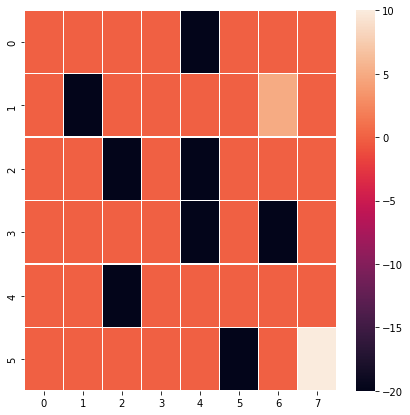

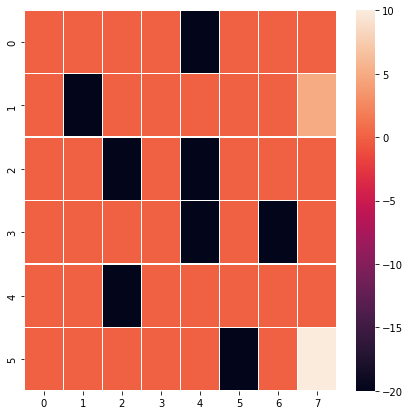

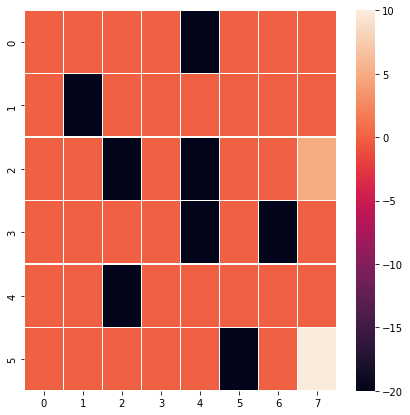

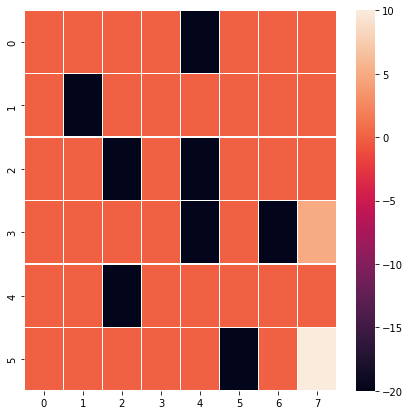

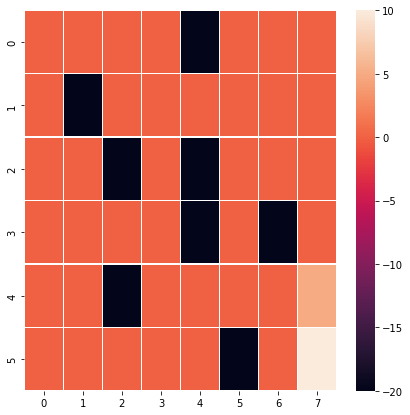

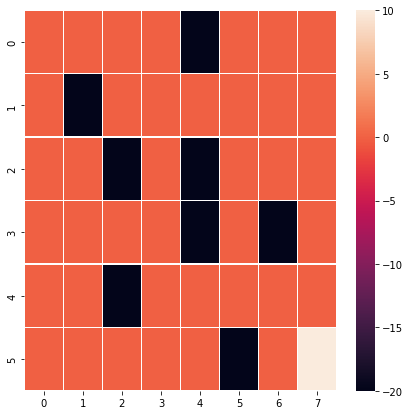

In [ ]:
def policy(state, Q):
    return np.argmax(Q[state])

state, R, done = env.reset()
env.show(state)
while not done:
    action = policy(state, Q)
    state, reward, done = env.step(state, action)
    R += reward
    env.show(state)
print(R)

---

## Off-Policy
Off-policy learning is more complicated. It uses two seperate policy arrays: one for exploritory downward selection behavior, and one to update the current target backup policy. Learning is from data *off* the downward selection policy, and the whole method is therefore called off-policy. The method that we discuss here is called $Q$-learning, and the update formula is:
$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \max_{a}(S_{t+1}, a) - Q(S_t, A_t)]
$$

The difference from on-policy learning is that the $\gamma Q(S_{t+1}, A_{t+1})$ term has been replaced by $\gamma \max_{a} Q(S_{t+1}, a)$. The learning is from backup values of the best, not the actual action. 

The reason that $Q$-learning is off-policy is that it updates its $Q$-values using the $Q$-value of the next state and the greedy action (not necessarily the policy selection action). In this sense, off-policy learning collects all available information and uses it simultaneously to construct the best target policy. 


---

In [ ]:
def q_learning(env, iterations =1_000):
    Q = {}
    for state in env.state_space:
        Q[state] = np.zeros(4)
    gamma = 0.7
    alpha = 0.2
    epsilon = 0.1
    R = []
    for episode in range(iterations):
        state, total_reward, done = env.reset()
        while not done:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.choice(env.action_space)
            else:
                action = np.argmax(Q[state])
            next_state, reward, done = env.step(state, action)
            next_max = np.max(Q[next_state])
            old_value = Q[state][action]

            new_value = old_value + alpha * (reward + gamma * next_max - old_value)

            Q[state][action] = new_value
            total_reward += reward
            state = next_state
        if episode % 100 == 0:
            print(f"Episode {episode} with total reward {total_reward}")
        R.append(total_reward)
    return Q, R

Episode 0 with total reward -27.0
Episode 100 with total reward -11.0
Episode 200 with total reward -4.0
Episode 300 with total reward -4.0
Episode 400 with total reward -4.0
Episode 500 with total reward -2.0
Episode 600 with total reward -4.0
Episode 700 with total reward -4.0
Episode 800 with total reward -2.0
Episode 900 with total reward -2.0


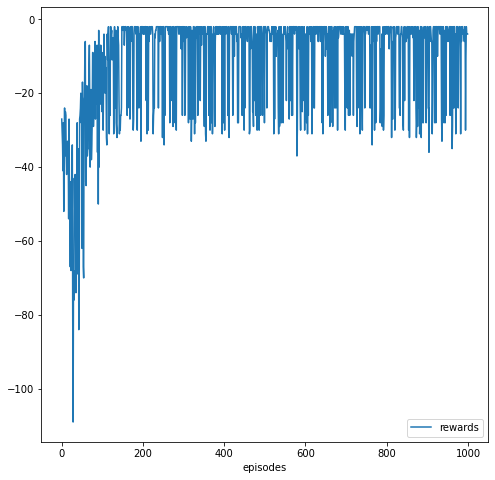

In [ ]:
Q1, R1 = q_learning(env)
plt.figure(figsize = (8, 8))
plt.plot(range(1_000), R1, label = "rewards")
plt.xlabel("episodes")
plt.legend()
plt.show()

-2.0


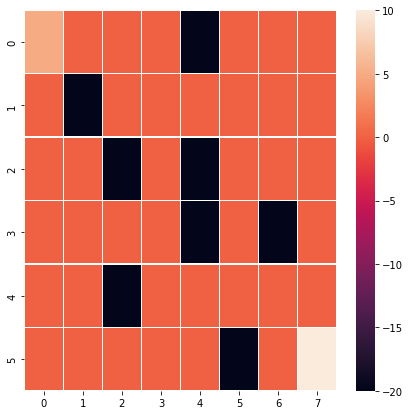

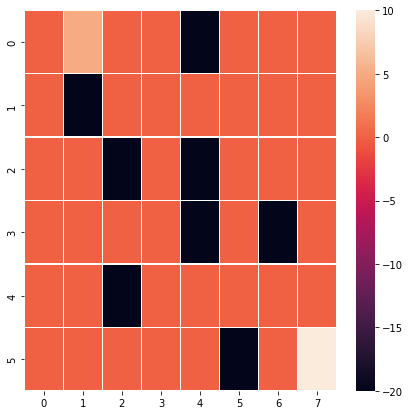

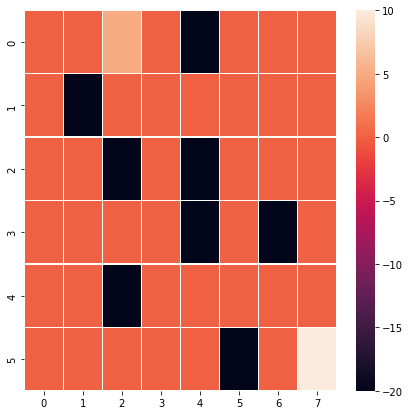

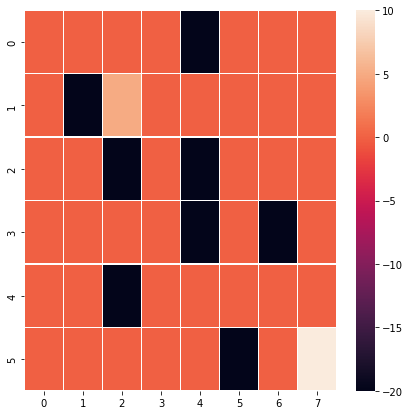

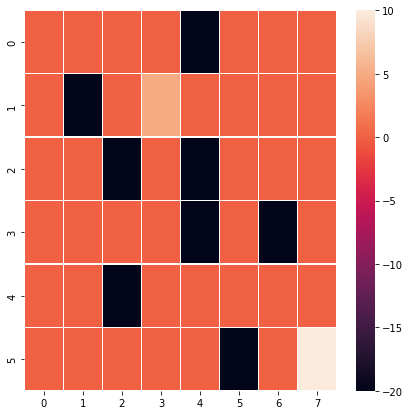

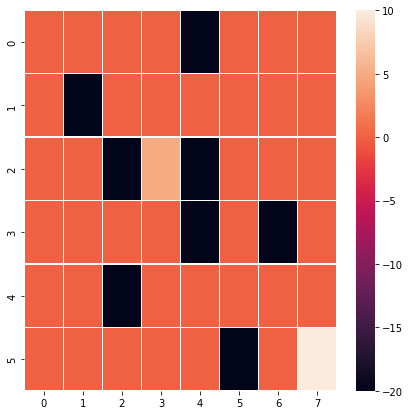

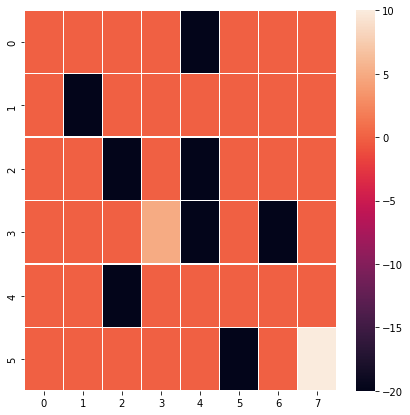

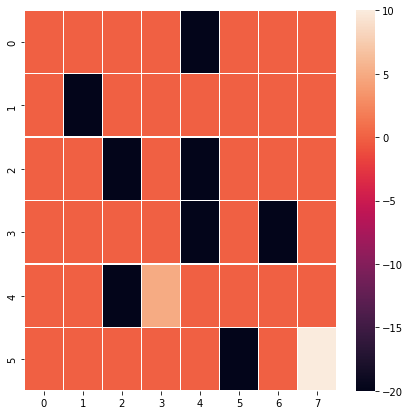

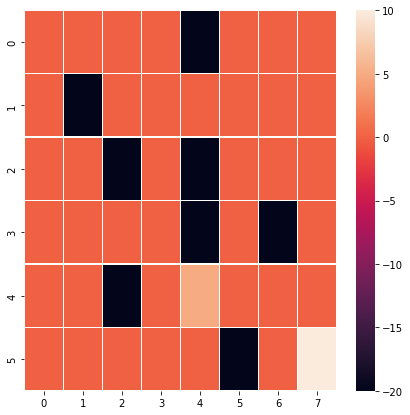

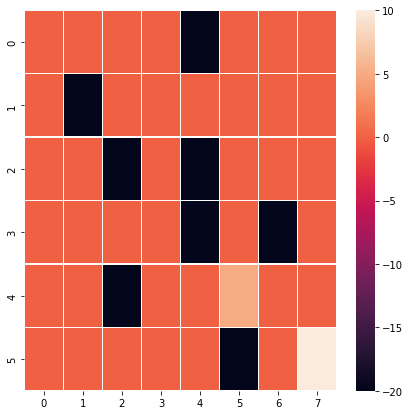

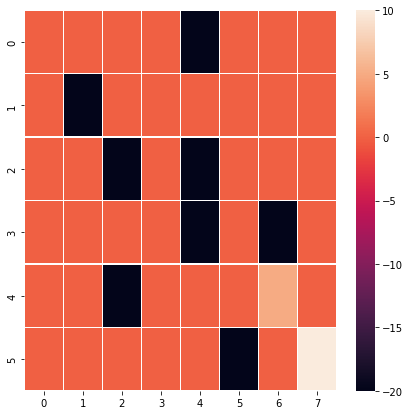

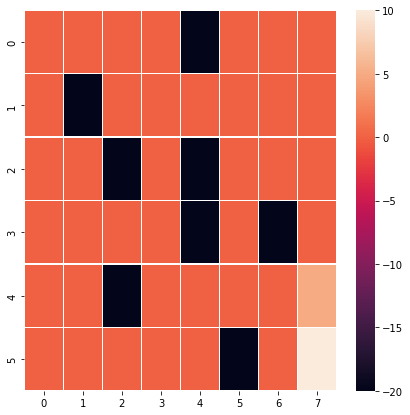

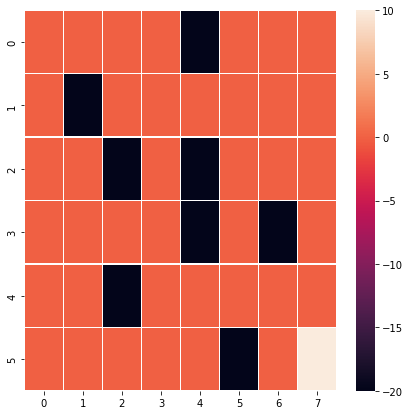

In [ ]:

state, R, done = env.reset()
env.show(state)
while not done:
    action = policy(state, Q1)
    state, reward, done = env.step(state, action)
    R += reward
    env.show(state)
print(R)

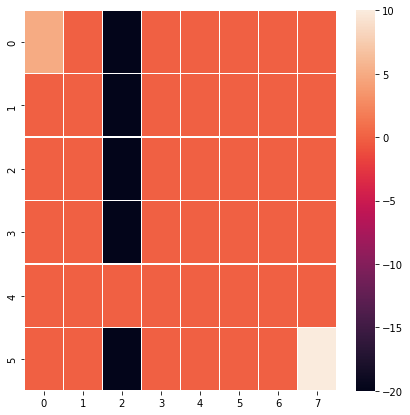

In [ ]:
initial_state = (0, 0)
grid_size = (6, 8)
items = {(5, 7): 10,
         (0, 2): -20,
         (1, 2): -20, 
         (2, 2): -20,
         (3, 2): -20, 
         (5, 2): -20}
terminal_states = items.keys()
env = GridWorld2(initial_state, grid_size, items, terminal_states)
env.show(initial_state)

Episode 0 with total reward -42.0
Episode 100 with total reward -4.0
Episode 200 with total reward -2.0
Episode 300 with total reward -2.0
Episode 400 with total reward -2.0
Episode 500 with total reward -2.0
Episode 600 with total reward -2.0
Episode 700 with total reward -3.0
Episode 800 with total reward -2.0
Episode 900 with total reward -3.0


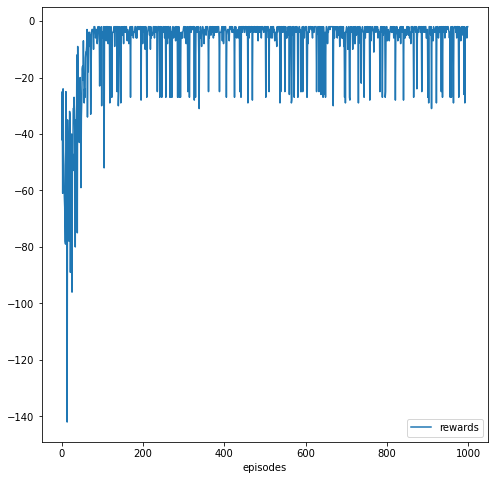

In [ ]:
Q1, R1 = q_learning(env)
plt.figure(figsize = (8, 8))
plt.plot(range(1_000), R1, label = "rewards")
plt.xlabel("episodes")
plt.legend()
plt.show()

-2.0


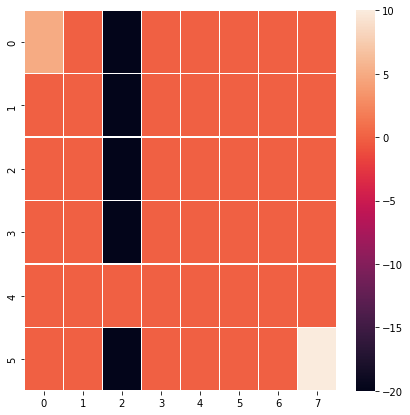

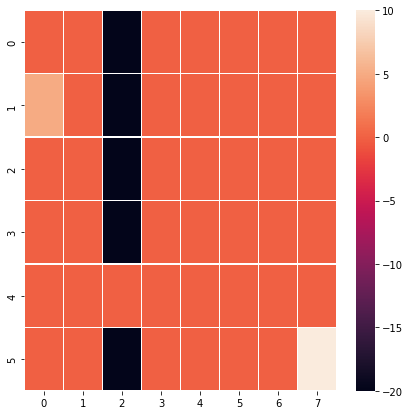

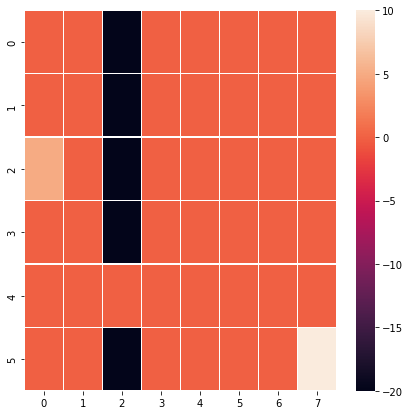

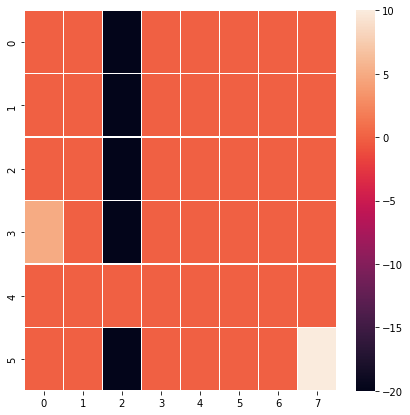

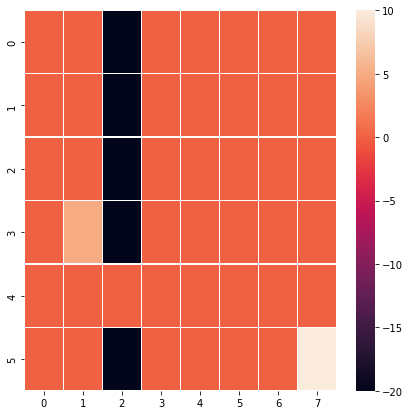

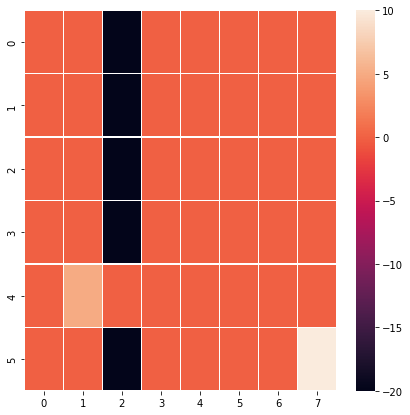

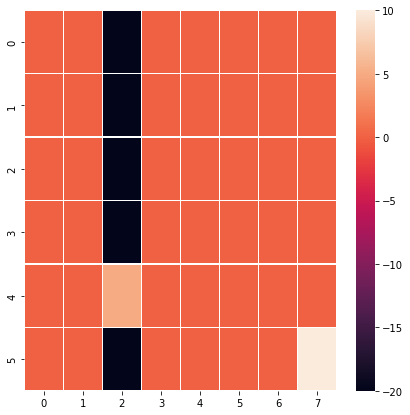

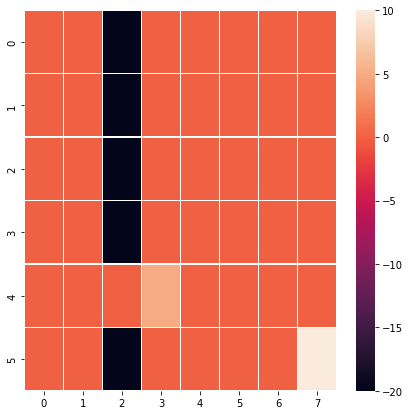

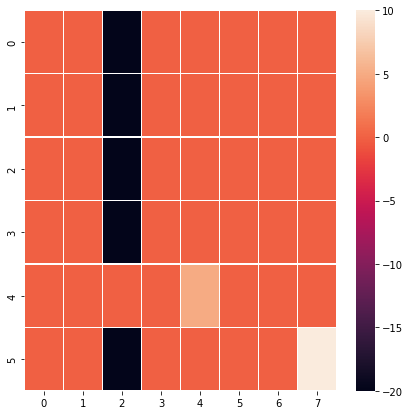

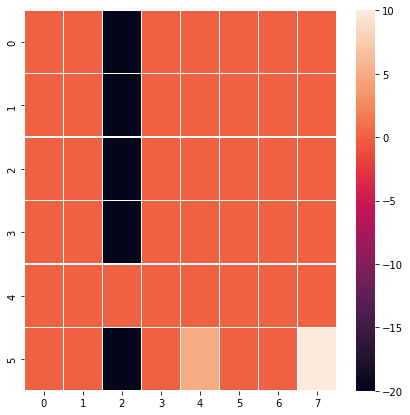

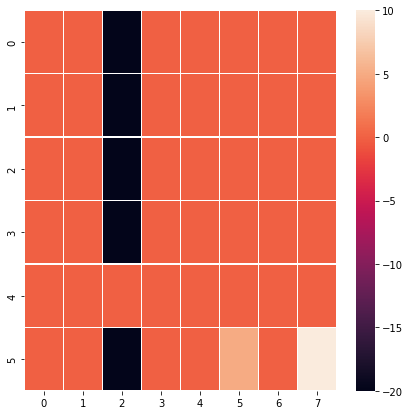

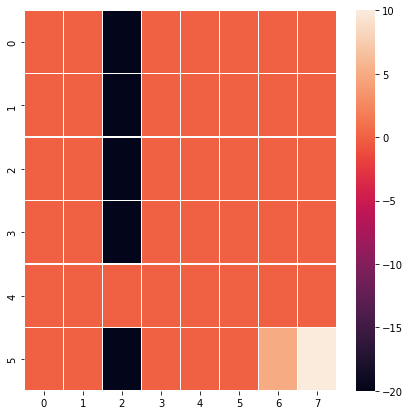

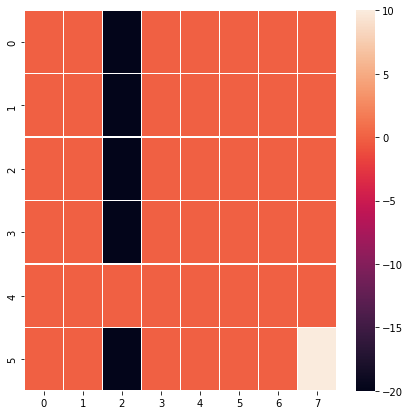

In [ ]:
state, R, done = env.reset()
env.show(state)
while not done:
    action = policy(state, Q1)
    state, reward, done = env.step(state, action)
    R += reward
    env.show(state)
print(R)

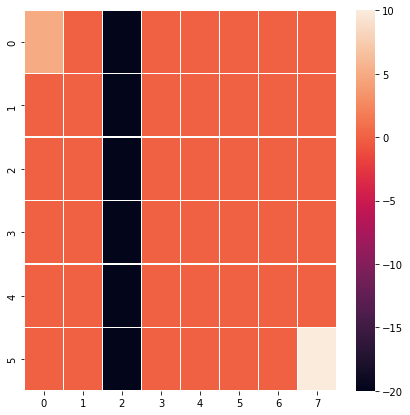

In [ ]:
initial_state = (0, 0)
grid_size = (6, 8)
items = {(5, 7): 10,
         (0, 2): -20,
         (1, 2): -20, 
         (2, 2): -20,
         (3, 2): -20, 
         (4, 2): -20,
         (5, 2): -20}
terminal_states = items.keys()
env = GridWorld2(initial_state, grid_size, items, terminal_states)
env.show(initial_state)

-26.0


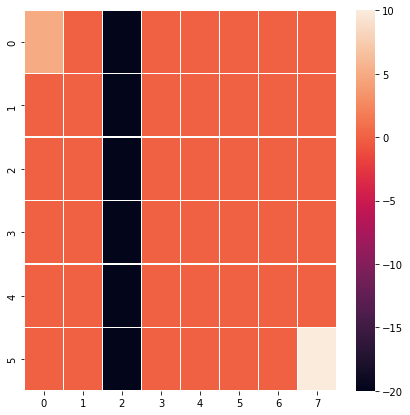

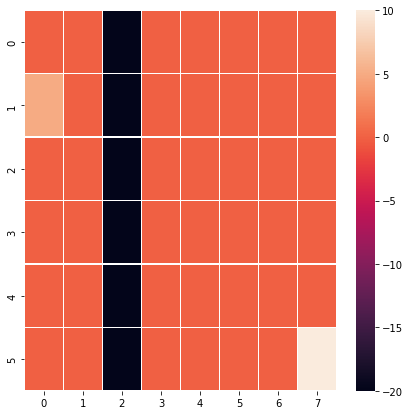

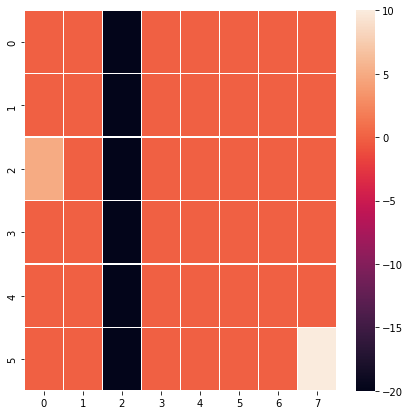

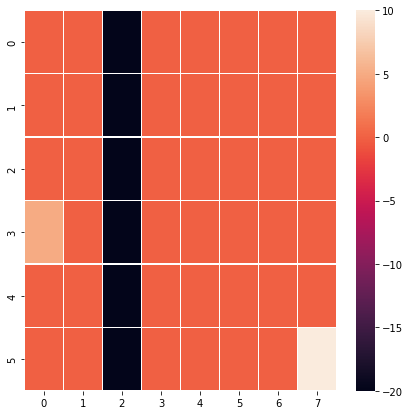

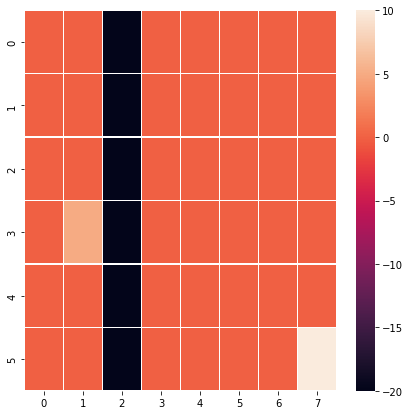

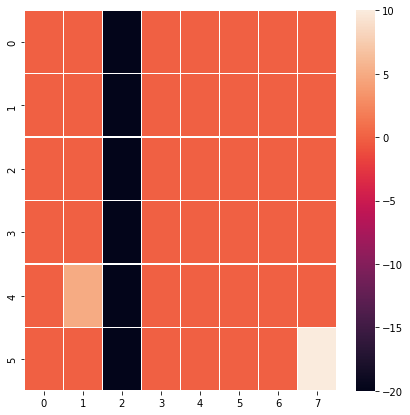

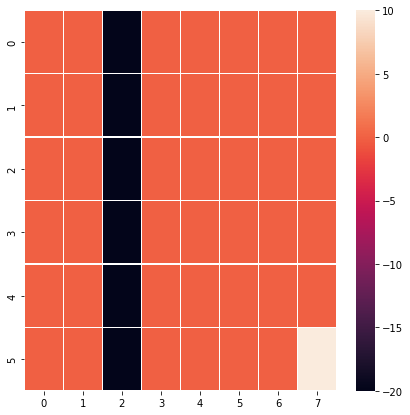

In [ ]:
state, R, done = env.reset()
env.show(state)
while not done:
    action = policy(state, Q1)
    state, reward, done = env.step(state, action)
    R += reward
    env.show(state)
print(R)

Episode 0 with total reward -29.0
Episode 100 with total reward -31.0
Episode 200 with total reward -32.0
Episode 300 with total reward -171.0
Episode 400 with total reward -38.0
Episode 500 with total reward -175.0
Episode 600 with total reward -82.0
Episode 700 with total reward -154.0
Episode 800 with total reward -92.0
Episode 900 with total reward -267.0


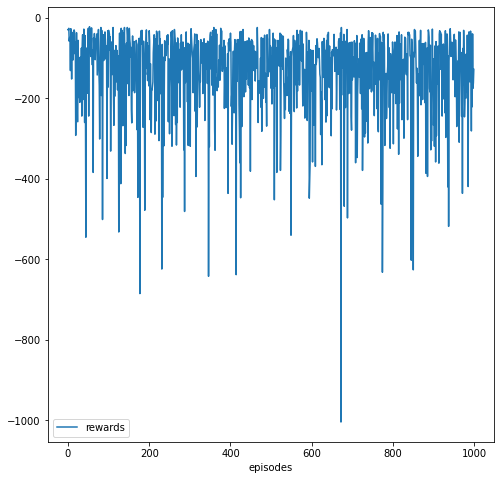

In [ ]:
Q1, R1 = q_learning(env)
plt.figure(figsize = (8, 8))
plt.plot(range(1_000), R1, label = "rewards")
plt.xlabel("episodes")
plt.legend()
plt.show()

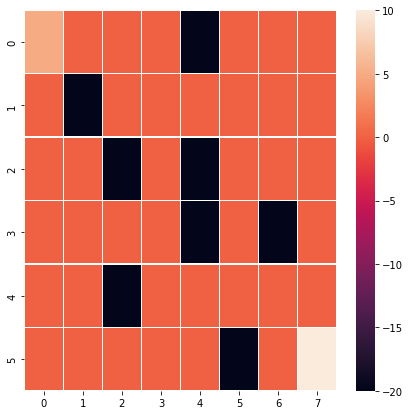

In [ ]:
initial_state = (0, 0)
grid_size = (6, 8)
items = {(5, 7): 10,
         (4, 2): -20,
         (2, 2): -20, 
         (2, 2): -20,
         (2, 2): -20, 
         (0, 4): -20, 
         (1, 1): -20, 
         (2, 4): -20,
         (3, 6): -20,
         (5, 5): -20, 
         (3, 4): -20}
terminal_states = items.keys()
env = GridWorld2(initial_state, grid_size, items, terminal_states)
env.show(initial_state)

Episode 0 with total reward -28.0
Episode 100 with total reward -29.0
Episode 200 with total reward -32.0
Episode 300 with total reward -16.0
Episode 400 with total reward -6.0
Episode 500 with total reward -2.0
Episode 600 with total reward -22.0
Episode 700 with total reward -27.0
Episode 800 with total reward -4.0
Episode 900 with total reward -8.0


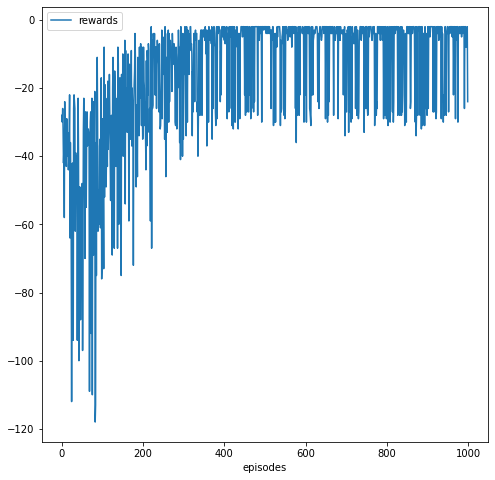

In [ ]:
Q1, R1 = q_learning(env)
plt.figure(figsize = (8, 8))
plt.plot(range(1_000), R1, label = "rewards")
plt.xlabel("episodes")
plt.legend()
plt.show()

In [ ]:
def q_learning(env, iterations =1_000):
    Q = {}
    for state in env.state_space:
        Q[state] = np.zeros(4)
    gamma = 0.9
    alpha = 0.05
    epsilon = 0.1
    R = []
    for episode in range(iterations):
        state, total_reward, done = env.reset()
        while not done:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.choice(env.action_space)
            else:
                action = np.argmax(Q[state])
            next_state, reward, done = env.step(state, action)
            next_max = np.max(Q[next_state])
            old_value = Q[state][action]

            new_value = old_value + alpha * (reward + gamma * next_max - old_value)

            Q[state][action] = new_value
            total_reward += reward
            state = next_state
        if episode % 100 == 0:
            print(f"Episode {episode} with total reward {total_reward}")
        R.append(total_reward)
    return Q, R